<a href="https://colab.research.google.com/github/brenttoast/C964_Project/blob/main/C964_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ipywidgets import interact, widgets
import requests
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

Set dataset folder and radio data filenames

In [183]:
data_folder = 'https://raw.githubusercontent.com/brenttoast/C964_Project/main/data/'
file_type = '.json'
radio_data = [
    'noc_bmd',
    'noc_bv',
    'noc_col',
    'noc_gwt',
    'noc_he',
    'noc_hg',
    'noc_hw',
    'noc_sar',
    'noc_tt',
    'noc_tur'
]

In [200]:
def json_download(url):
    response = requests.get(url)
    response.raise_for_status()
    return response.json()

train_temperature = json_download(f'{data_folder}temps{file_type}')
train_temperature = pd.DataFrame(train_temperature).rename(columns={"dt": "time"})
train_temperature = train_temperature[['time', 'main']]
train_temperature['temp'] = train_temperature['main'].apply(lambda x: x['temp'])
train_temperature = train_temperature[['time', 'temp']]
train_temperature['time'] = pd.to_datetime(train_temperature['time'], unit='s')
train_temperature['time'] = train_temperature['time'].dt.tz_localize('Etc/GMT+3')
train_temperature['temp_change'] = train_temperature['temp'].diff()
train_temperature = train_temperature.iloc[1:]
radio_stats_all = []

for json_file in radio_data:
    radio_info = json_download(f'{data_folder}{json_file}{file_type}')
    
    azimuth = radio_info['meta']['azimuth']
    height = radio_info['meta']['height']
    radio_info = pd.DataFrame(radio_info["data"]).rename(columns={"sensor": "rsl"})
    radio_info['link_name'] = f'{json_file}'
    radio_info['time'] = pd.to_datetime(radio_info['time'], format='%Y-%m-%d %H:%M:%S')
    radio_info['time'] = radio_info['time'].dt.tz_localize('US/Pacific')
    radio_info = pd.merge(radio_info, train_temperature, on='time')
    radio_info['rsl_delta'] = abs(radio_info['rsl'] - stats.mode(radio_info['rsl'])[0])
    radio_info['azimuth'] = azimuth
    radio_info['azimuth_sin'] = np.sin(np.radians(azimuth))
    radio_info['azimuth_cos'] = np.cos(np.radians(azimuth))
    radio_info['height'] = height
    radio_stats_all.extend(radio_info.to_dict(orient='records'))

df = pd.DataFrame(radio_stats_all)

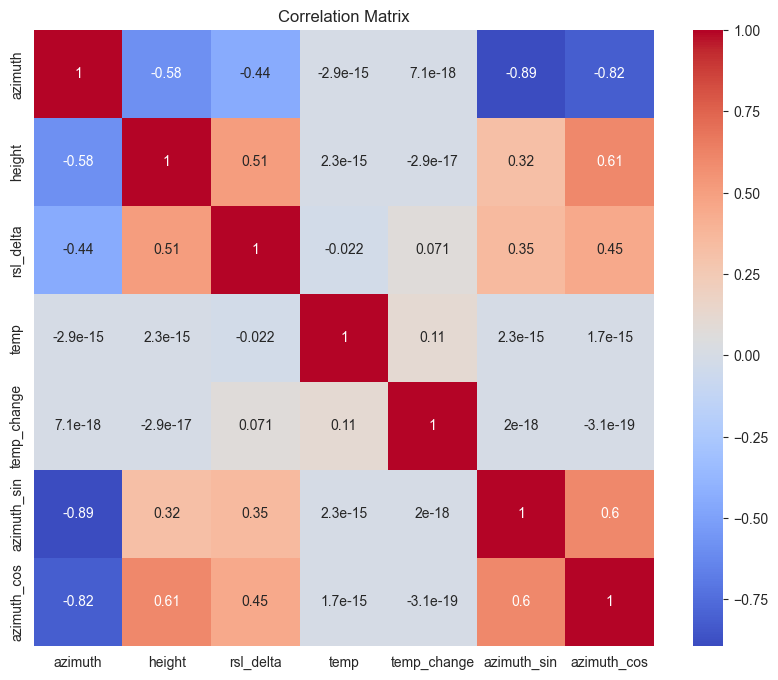

,time,rsl,link_name,temp,temp_change,rsl_delta,azimuth,azimuth_sin,azimuth_cos,height
0,2024-05-10 21:00:00-07:00,-38.000000,noc_bmd,32.22,-0.62,0.000000,190.43,-0.181034,-0.983477,35.1
1,2024-05-10 22:00:00-07:00,-37.000000,noc_bmd,31.03,-1.19,1.000000,190.43,-0.181034,-0.983477,35.1
2,2024-05-10 23:00:00-07:00,-38.000000,noc_bmd,23.74,-7.29,0.000000,190.43,-0.181034,-0.983477,35.1
3,2024-05-11 00:00:00-07:00,-37.506111,noc_bmd,23.44,-0.30,0.493889,190.43,-0.181034,-0.983477,35.1
4,2024-05-11 01:00:00-07:00,-38.000000,noc_bmd,20.72,-2.72,0.000000,190.43,-0.181034,-0.983477,35.1


In [201]:
corr_matrix = df[['azimuth', 'height', 'rsl_delta', 'temp', 'temp_change', 'azimuth_sin', 'azimuth_cos']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

df.head()

In [202]:
X = df[['temp', 'temp_change', 'height', 'azimuth_sin', 'azimuth_cos']]
y = (df['rsl_delta'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# regressor = GradientBoostingRegressor()
# 
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 4, 5],
#     'min_samples_split': [2, 5, 10]
# }

model = RandomForestRegressor(random_state=42)# GridSearchCV(estimator=regressor, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
model.fit(X_train, y_train)

# model = model.best_estimator_

y_prediction = model.predict(X_test)

mae = mean_absolute_error(y_test, y_prediction)
mse = mean_squared_error(y_test, y_prediction)
r2 = r2_score(y_test, y_prediction)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R^2: {r2}")

MAE: 0.2999875162696341
MSE: 0.23697280215753
R^2: 0.9045170828455391


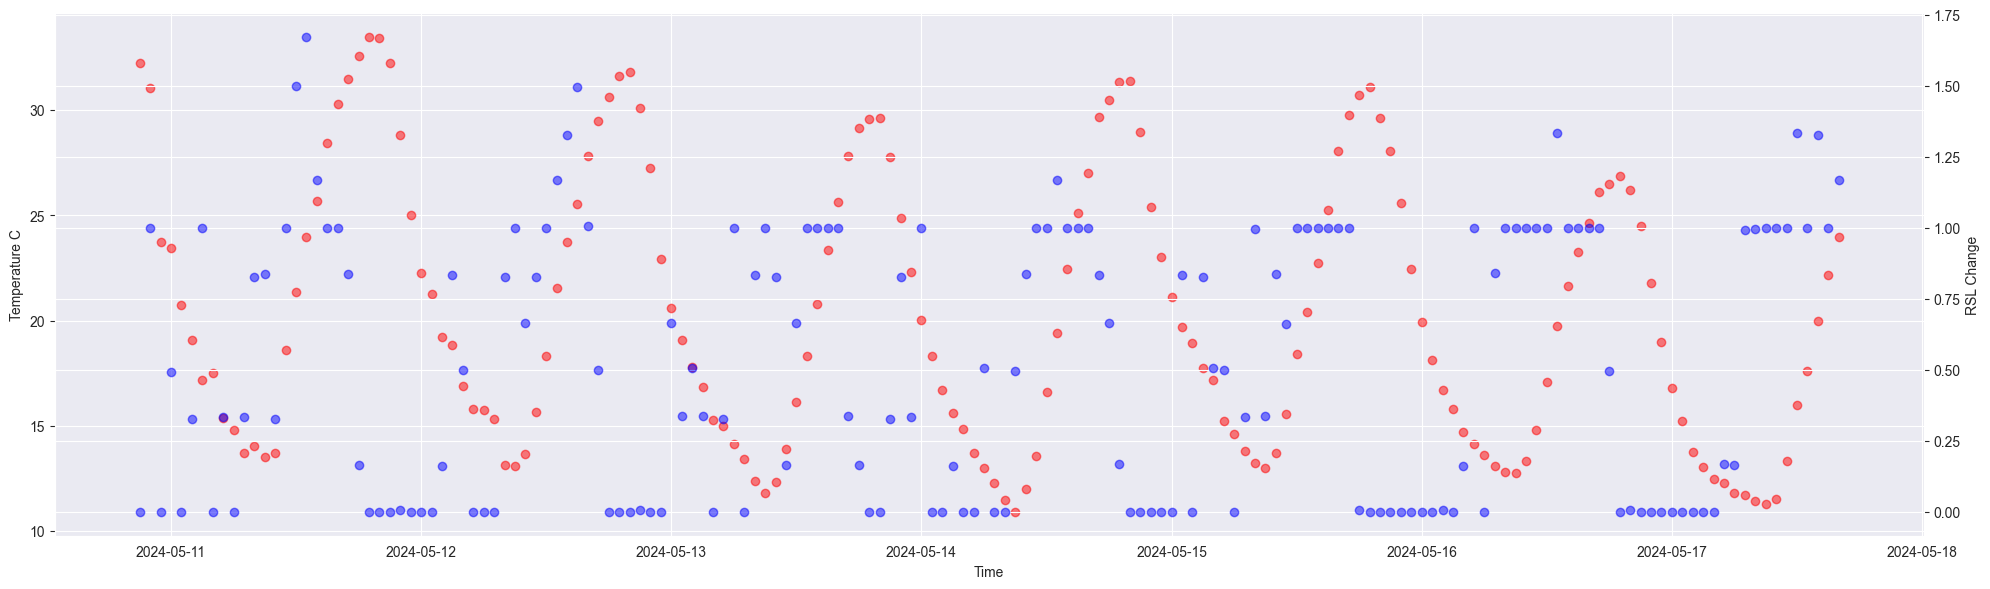

TypeError: _InteractFactory.__call__() takes from 1 to 2 positional arguments but 3 were given

In [203]:
link_name_list = df['link_name'].unique()
link_name_list = widgets.Dropdown(options=link_name_list, value=link_name_list[0], description='Select Link: ')

def plot_temp_rsl_change(link_name):
    
    link_data = df[df['link_name'] == link_name]
    
    fig, ax1 = plt.subplots(figsize=(20, 6))
    
    ax1.scatter(link_data['time'], link_data['temp'], alpha = 0.5, label='Temperature', color='red')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Temperature C')
    ax1.tick_params(axis='y')
    
    ax2 = ax1.twinx()
    ax2.scatter(link_data['time'], link_data['rsl_delta'], alpha=0.5, label='RSL Change', color='blue')
    ax2.set_ylabel('RSL Change')
    ax2.tick_params(axis='y')
    
    fig.tight_layout()
    plt.show()
    
interact(plot_temp_rsl_change(link_name_list.value), link_name_list)

In [204]:
def plot_rsl_change(input_height=35, input_azimuth=0):
    temperatures = np.arange(10, 35, 1)
    predicted_rsl = []

    for temp in temperatures:
        inputs = pd.DataFrame({
            'temp': [temp], 'height': [input_height],
            'azimuth_sin': [np.sin(np.radians(input_azimuth))],
            'azimuth_cos': [np.cos(np.radians(input_azimuth))],
        })
        predicted_rsl.append(model.predict(inputs)[0])

    plt.figure(figsize=(10, 6))
    plt.plot(temperatures, predicted_rsl)
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Potential RSL Change (dBm)')
    plt.yticks(np.arange(0, 5, 0.5))
    plt.ylim(0, 5)
    plt.title(f'RSL Change vs. Temperature (Height: {input_height}m, Azimuth: {input_azimuth}°)')
    plt.grid(True)
    plt.show()


interact(plot_rsl_change,
         input_height=widgets.IntSlider(min=30, max=60, step=1, value=35, description='Height (m)'),
         input_azimuth=widgets.IntSlider(min=0, max=360, step=1, value=0, description='Azimuth (°)'))


interactive(children=(IntSlider(value=35, description='Height (m)', max=60, min=30), IntSlider(value=0, descri…

<function __main__.plot_rsl_change(input_height=35, input_azimuth=0)>